In [356]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [357]:
df = pd.read_csv('labeled_data.csv', sep=';')
df.shape

(37636, 26)

In [358]:
df.columns

Index(['ID', 'Maker', ' Genmodel', ' Genmodel_ID', 'Adv_year', 'Adv_month',
       'Color', 'Reg_year', 'Bodytype', 'Runned_Miles', 'Engin_size',
       'Gearbox', 'Fuel_type', 'Price', 'Seat_num', 'Door_num', 'issue',
       'issue_id', 'Adv_day', 'breakdown_date', 'repair_complexity',
       'repair_cost', 'repair_hours', 'repair_date', 'value', 'Label'],
      dtype='object')

In [359]:
df = df.drop('ID', axis=1)  # drop "Id" column as uninformative

In [360]:
# define function to uniformly format column names (remove whitespaces and change to lowercase)
def clean_column_names(df):
    df = df.rename(columns=lambda x: x.strip().lower())
    return df

In [361]:
# apply the newly defined function
df = clean_column_names(df)
df.columns

Index(['maker', 'genmodel', 'genmodel_id', 'adv_year', 'adv_month', 'color',
       'reg_year', 'bodytype', 'runned_miles', 'engin_size', 'gearbox',
       'fuel_type', 'price', 'seat_num', 'door_num', 'issue', 'issue_id',
       'adv_day', 'breakdown_date', 'repair_complexity', 'repair_cost',
       'repair_hours', 'repair_date', 'value', 'label'],
      dtype='object')

In [362]:
# solve minor column name issues
df.rename(columns={'engin_size': 'engine_size', 'runned_miles': 'mileage'}, inplace=True)
df.columns

Index(['maker', 'genmodel', 'genmodel_id', 'adv_year', 'adv_month', 'color',
       'reg_year', 'bodytype', 'mileage', 'engine_size', 'gearbox',
       'fuel_type', 'price', 'seat_num', 'door_num', 'issue', 'issue_id',
       'adv_day', 'breakdown_date', 'repair_complexity', 'repair_cost',
       'repair_hours', 'repair_date', 'value', 'label'],
      dtype='object')

In [363]:
# check for NaNs
df.isnull().sum().any()

False

In [364]:
# check for duplicate rows
df.duplicated().any()

False

## Clean numerical features

In [365]:
# define a function to find indices for outliers in a column
def find_outliers(feature):

    # Convert input to numpy array
    data = np.array(feature)
    
    # Calculate Q1, Q3, and IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
    
    return outlier_indices.tolist()

In [366]:
# describe numerical features
df.select_dtypes(np.number).describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
adv_year,37636.0,2006.10,147.53,202.0,2018.00,2018.00,2018.00,2021.00
adv_month,37636.0,5.68,2.07,1.0,4.00,5.00,7.00,13.00
reg_year,37636.0,2012.38,4.57,1960.0,2009.00,2013.00,2016.00,2019.00
mileage,37636.0,48194.86,39475.09,-19826.0,15389.75,39249.00,74204.50,900000.00
price,37636.0,11840.00,34044.82,125.0,3500.00,7343.50,11990.00,2599990.00
seat_num,37636.0,5.11,1.64,2.0,5.00,5.00,5.00,20.00
door_num,37636.0,4.35,1.12,0.0,3.00,5.00,5.00,7.00
issue_id,37636.0,0.50,1.13,0.0,0.00,0.00,0.00,5.00
adv_day,37636.0,14.49,8.09,1.0,7.00,14.00,22.00,28.00
repair_complexity,37636.0,1.28,0.55,1.0,1.00,1.00,1.00,4.00


<Axes: >

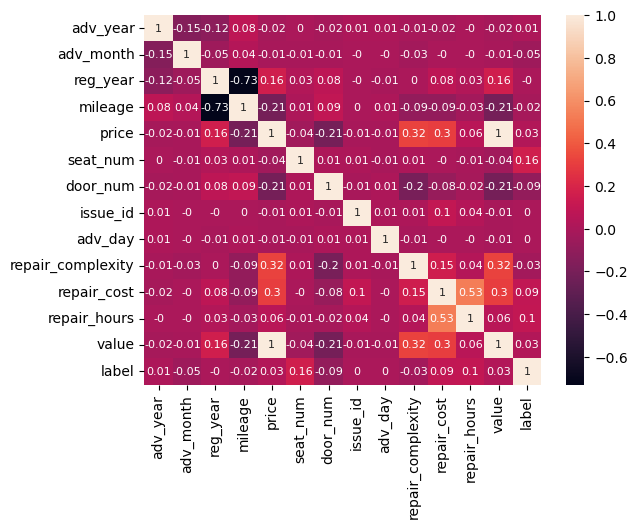

In [367]:
# First check how much numerical features correlate with one another

corr_matrix = df.select_dtypes(np.number).corr().round(2)
sns.heatmap(corr_matrix, annot=True, annot_kws={'size': 8})

In [368]:
# Features 'price' and 'value' appears to be the same variable.

# drop 'value'
df = df.drop('value', axis=1)

In [369]:
# 'adv_year' feature contains oddly low minimum value
# count number of cars an advertisement year lower than 1950
df['adv_year'][df['adv_year'] < 1950].shape[0]

250

In [370]:
# We have 250 unreasonably old dates
# check if there is any variability in those
df['adv_year'][df['adv_year'] < 1950].unique()

array([202], dtype=int64)

In [371]:
# No variability: 250 values have 'adv_year' equal to 202
# this number should most likely stand for 2020, hence replace the values
df['adv_year'] = df['adv_year'].replace(202, 2020)
# check the frequency distribution for different years
df.groupby('adv_year').size()

adv_year
2012        1
2013        2
2014        5
2015       10
2016       62
2017     1366
2018    33302
2019       21
2020      250
2021     2617
dtype: int64

In [372]:
# looks credible

# Now let's check 'adv_month' feature
df.groupby('adv_month').size()

adv_month
1      736
2     1346
3     2969
4     6049
5     8772
6     3376
7     5314
8     7761
9      301
10     279
11     368
12     364
13       1
dtype: int64

In [373]:
# Month 13 most likely belongs to 12, hence replace the value
df['adv_month'] = df['adv_month'].replace(13, 12)

In [374]:
# check advertisment day
df.groupby('adv_day').size()

adv_day
1     1331
2     1361
3     1356
4     1315
5     1350
6     1323
7     1431
8     1408
9     1372
10    1316
11    1305
12    1366
13    1313
14    1343
15    1299
16    1353
17    1285
18    1290
19    1337
20    1371
21    1340
22    1378
23    1344
24    1409
25    1316
26    1387
27    1284
28    1353
dtype: int64

In [375]:
# looks ok overall though kind of strange to have 28 days for each month

# Let's combine advertisement day, month and year into one date feature and drop redundant columns
df['adv_date'] = pd.to_datetime({'year': df['adv_year'], 'month': df['adv_month'], 'day': df['adv_day']})
df = df.drop(['adv_year', 'adv_month', 'adv_day'], axis=1)

In [376]:
# check the most recent advertisement dates to find a feasible reference point for calculating advertisement recency
df['adv_date'].sort_values().tail(3)

2882    2021-06-28
18822   2021-06-28
16943   2021-06-28
Name: adv_date, dtype: datetime64[ns]

<Axes: xlabel='adv_recency', ylabel='Count'>

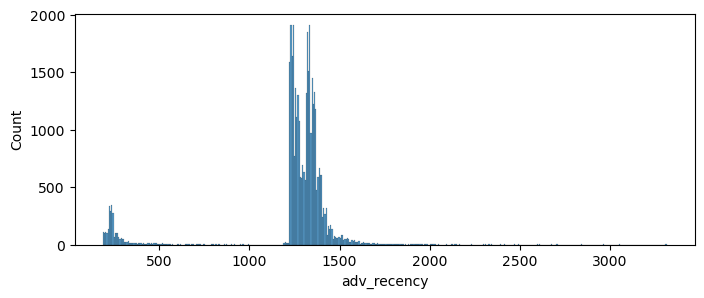

In [377]:
# let's use 2022-01-01 as a reference date
reference_date = pd.to_datetime('2022-01-01')

# distance to the reference date in days (recency)
df['adv_recency'] = (reference_date - df['adv_date']).dt.days

# extract additional features to represent possible cyclic predictors such as weekday and month
df['month'] = df['adv_date'].dt.month
df['weekday'] = df['adv_date'].dt.weekday

df = df.drop('adv_date', axis=1)  # drop 'adv_date' as redundant

# plot the distribution plot for 'adv_recency'
plt.figure(figsize=(8, 3))
sns.histplot(df['adv_recency'])

In [378]:
# 'adv_recency' distribution is far from normal
# hence apply log transformation
df['adv_recency_log'] = np.log1p(df['adv_recency'])

df = df.drop('adv_recency', axis=1)  # drop 'adv_recency' as redundant

# and use RobustScaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df['adv_recency_scaled'] = scaler.fit_transform(df[['adv_recency_log']])

# drop 'adv_recency_log' as redundant
df = df.drop('adv_recency_log', axis=1)

In [379]:
# check the newly engineered features, first check weekdays
df['weekday'].value_counts().sort_index()

weekday
0    5441
1    5374
2    5319
3    5282
4    5442
5    5424
6    5354
Name: count, dtype: int64

In [380]:
# check months
df['month'].value_counts().sort_index()

month
1      736
2     1346
3     2969
4     6049
5     8772
6     3376
7     5314
8     7761
9      301
10     279
11     368
12     365
Name: count, dtype: int64

In [381]:
# Features like month and weekday are cyclic (e.g., December is close to January, Sunday to Monday etc.)
# Logistic regression treats them as linear, which can miss this relationship
# We will encode them as sin/cos pairs to capture their cyclic nature:

# cyclic encoding for month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# cyclic encoding for weekday
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

# Drop adv_day, month and weekday as we don't need them anymore
df = df.drop(['month', 'weekday'], axis=1)

<Axes: xlabel='reg_year', ylabel='Count'>

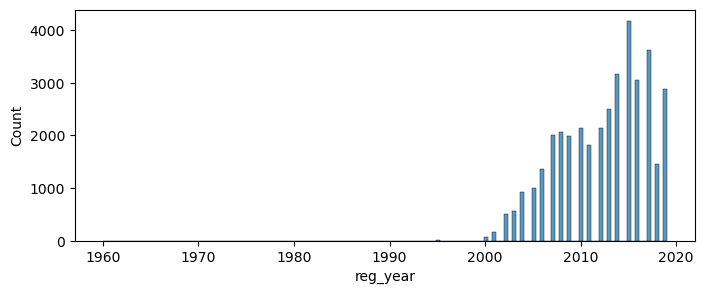

In [382]:
# Check 'reg_year' distribution
plt.figure(figsize=(8, 3))
sns.histplot(df['reg_year'])

In [383]:
# Instead of using the absolute year (reg_year), let's calculate the age of the vehicle by subtracting reg_year from a reference year
# This captures the recency of the vehicle (e.g., newer vehicles might be more likely to have a positive label)

# calculate vehicle age (using 2022 as reference)
df['vehicle_age'] = 2022 - df['reg_year']

# drop 'reg_year'
df = df.drop('reg_year', axis = 1)

# log transform the feature as it looks highly left skewed
df['vehicle_age_log'] = np.log1p(df['vehicle_age'])

# use RobustScaler
scaler = RobustScaler()
df['vehicle_age_scaled'] = scaler.fit_transform(df[['vehicle_age_log']])

# drop 'vehicle_age_log' and 'vehicle_age' as redundant
df = df.drop(['vehicle_age', 'vehicle_age_log'], axis=1)


<Axes: xlabel='mileage', ylabel='Count'>

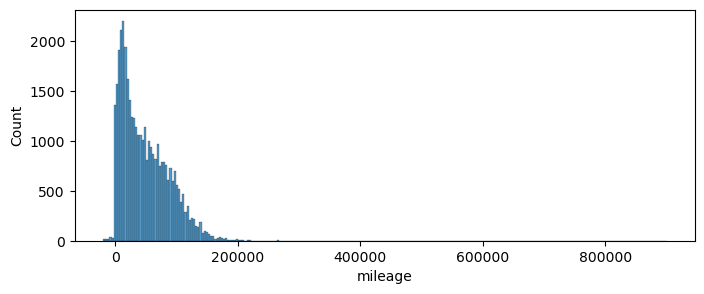

In [384]:
# Check 'mileage' feature
plt.figure(figsize=(8, 3))
sns.histplot(df['mileage'])

In [385]:
# count negative values
df.query('mileage < 0').shape[0]

134

<Axes: xlabel='mileage', ylabel='Count'>

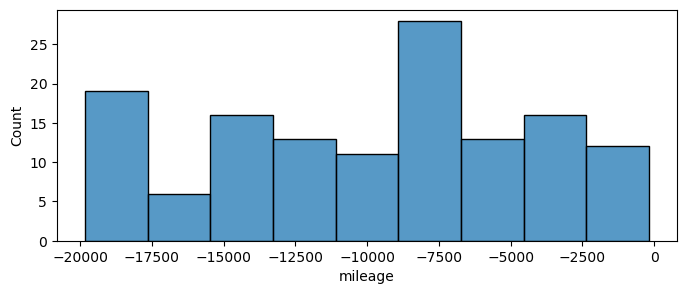

In [386]:
# check detailed distribution of negative values for 'mileage'
plt.figure(figsize=(8, 3))
sns.histplot(df['mileage'][df['mileage'] < 0])

In [387]:
# looks like negative sign is a typo here
# let's convert negative mileage to positive
df['mileage'] = df['mileage'].abs()
# log transform the feature
df['mileage_log'] = np.log1p(df['mileage'])

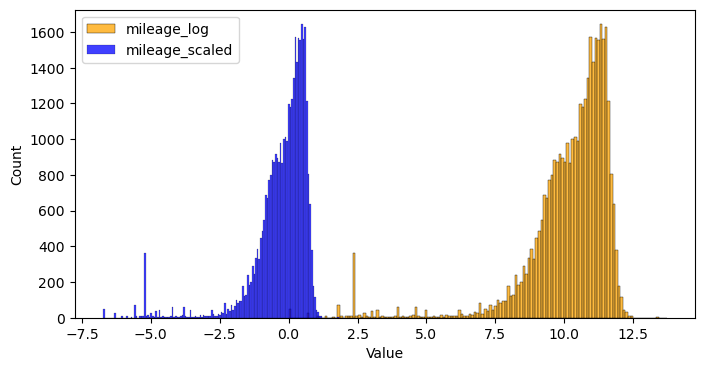

In [388]:
# To reduce the impact of outliers on the logistic regression model, apply RobustScaler to the feature
scaler = RobustScaler()
df['mileage_scaled'] = scaler.fit_transform(df[['mileage_log']])

# Visualize the resulting disctribution change
plt.figure(figsize=(8, 4))
sns.histplot(df['mileage_log'], color='orange', label='mileage_log')
sns.histplot(df['mileage_scaled'], color='blue', label='mileage_scaled')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend()
plt.show()

In [389]:
# Drop 'mileage_log' and 'mileage'
df = df.drop(columns=['mileage', 'mileage_log'])

<Axes: xlabel='price', ylabel='Count'>

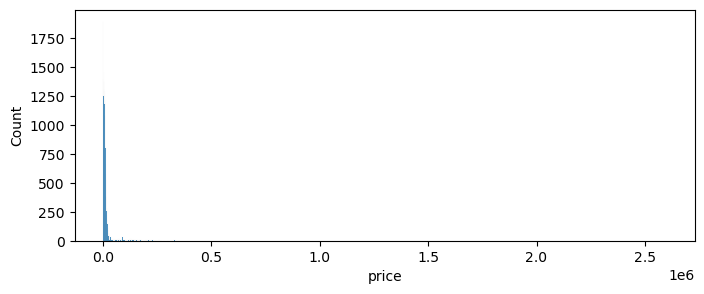

In [390]:
# Vizualise the distribution of the 'price' feature
plt.figure(figsize=(8, 3))
sns.histplot(df['price'])

In [391]:
# 'price' feature is heavily right skewed
# let's check 10 lowest values
df['price'].sort_values().head(10)

28015    125.0
21484    150.0
32137    180.0
174      195.0
12595    195.0
18814    199.0
2321     200.0
22214    200.0
33684    200.0
36126    200.0
Name: price, dtype: float64

In [392]:
# check 10 highest 'price' values
df['price'].sort_values().tail(10)

31763     350000.0
1319      399950.0
32506     459990.0
16699     535000.0
6882      599950.0
28321    1250000.0
31892    2000000.0
28611    2195000.0
20088    2500000.0
5582     2599990.0
Name: price, dtype: float64

In [393]:
# All outliers seem to be real numbers as it is not impossible to sell used cars very cheap and premium cars very expensive
# Still let's check how many outliers we have
price_outliers_indices = find_outliers(df['price'])
print(len(df['price'][price_outliers_indices]))

1958


In [394]:
# Too many outliers. Let's log-transform the feature and check if it helped
df['log_price'] = np.log1p(df['price'])
price_outliers_indices = find_outliers(df['log_price'])
print(len(df['log_price'][price_outliers_indices]))

1130


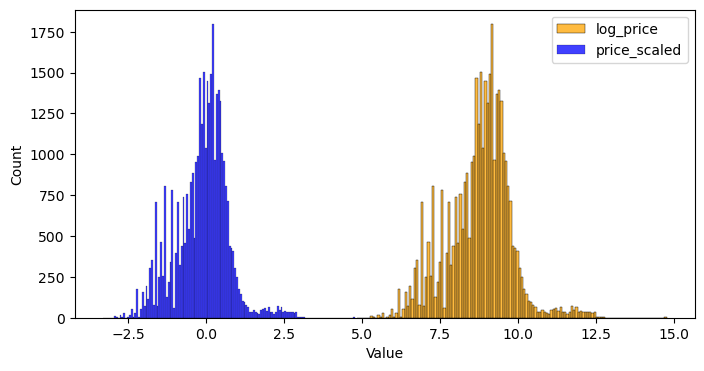

In [395]:
# We still have quite a large number of outliers which can be detrimental to the quality of predictive model
# To reduce their impact on the logistic regression model, let's apply RobustScaler (instead of StandardScaler)
scaler = RobustScaler()
df['price_scaled'] = scaler.fit_transform(df[['log_price']])

# Let's visualize the resulting disctribution change
plt.figure(figsize=(8, 4))
sns.histplot(df['log_price'], color='orange', label='log_price')
sns.histplot(df['price_scaled'], color='blue', label='price_scaled')
plt.xlabel('Value')
plt.ylabel('Count')
plt.legend()
plt.show()

In [396]:
# Drop 'price' and 'log_price'
df = df.drop(columns=['price', 'log_price'])

In [397]:
# Check the frequency for each 'seat_num" case
df['seat_num'].value_counts().sort_index()

seat_num
2.0       654
3.0        27
4.0      6233
5.0     27278
6.0       149
7.0      2516
8.0        38
9.0        31
10.0       61
11.0       71
12.0       57
13.0       56
14.0       74
15.0       72
16.0       67
17.0       53
18.0       65
19.0       70
20.0       64
Name: count, dtype: int64

In [398]:
# While seat_num is numeric (integers), its distribution suggests it behaves more like a categorical feature
# The long tail (8–20 seats) has low frequencies, and these rare values may not add much predictive power
# Let's group the values into bins based on frequency and practical significance:
# 2–3 seats: Small vehicles (e.g., sports cars, compact cars)
# 4–5 seats: Standard vehicles (most common)
# 6–7 seats: Larger family vehicles or SUVs
# 8+ seats: Vans, buses, or specialty vehicles

bins = [2, 3, 5, 7, 20]  # Define bin edges
labels = ['2-3', '4-5', '6-7', '8+']  # Bin labels
df['seat_num_binned'] = pd.cut(df['seat_num'], bins=bins, labels=labels, include_lowest=True)

# One-hot encode the binned feature
df = pd.get_dummies(df, columns=['seat_num_binned'], prefix='seat_num', drop_first=True)

# Drop integer 'seat_num'
df = df.drop('seat_num', axis=1)

In [399]:
# check 'door_num' feature
df['door_num'].value_counts().sort_index()

door_num
0.0      606
2.0     1828
3.0     7536
4.0     1113
5.0    26482
6.0       70
7.0        1
Name: count, dtype: int64

In [400]:
# The presence of 606 vehicles with 0 doors is unusual and might indicate either missing data or special vehicles (e.g. motorcycles)
# Let's check how these vehicles are associated with 'bodytype'
df[df['door_num'] == 0].groupby('bodytype').size()

bodytype
Car Derived Van      1
Combi Van            2
Convertible         46
Coupe               78
Estate              69
Hatchback          234
MPV                 64
Pickup               8
SUV                 18
Saloon              18
Wood                68
dtype: int64

In [401]:
# It is obvious now that zero-doored vehicles refer to a missing value placeholder. Dropping relevant rows seems unpractical
# The most direct solution would be imputing the mode of 'door_num' which is 5 doors (~70% of all cases)
# Additionaly we will bin and one-hot-encode the feature

df['door_num'] = df['door_num'].replace(0, 5)  # Impute 0 as 5
bins = [2, 3, 5, 7]
labels = ['2-3', '4-5', '6+']
df['door_num_binned'] = pd.cut(df['door_num'], bins=bins, labels=labels, include_lowest=True)

# One-hot encode the binned feature
df = pd.get_dummies(df, columns=['door_num_binned'], prefix='door_num', drop_first=True)

# Drop 'door_num'
df = df.drop(['door_num'], axis=1)

In [402]:
# Check 'issue_id'
df['issue_id'].value_counts()

issue_id
0    30092
2     2046
1     1942
3     1906
4     1196
5      454
Name: count, dtype: int64

In [403]:
# It is not clear what information this feature represents but most likely the number of issues or defects identified with a vehicle
# It looks plausible that the majority of sold cars had no defects and that the number of cars decreases with the number of identified issues
# Seems reasonable to treat this feature like the previous one which implies binning to reduce dimensionality, and one-hot-encoding

bins = [0, 1, 3, 5]
labels = ['0', '1-2', '3+']
df['issue_id_binned'] = pd.cut(df['issue_id'], bins=bins, labels=labels, include_lowest=True)

# One-hot encode
df = pd.get_dummies(df, columns=['issue_id_binned'], prefix='issue_id', drop_first=True)

# drop 'issue_id'
df = df.drop(['issue_id'], axis=1)

In [404]:
# Check 'repair_complexity'
df['repair_complexity'].value_counts()

repair_complexity
1    28739
2     7292
3     1510
4       95
Name: count, dtype: int64

In [405]:
# bin and one-hot-encode 'repair_complexity'
bins = [0, 1, 2, 4]
labels = ['1', '2', '3-4']
df['repair_complexity_binned'] = pd.cut(df['repair_complexity'], bins=bins, labels=labels, include_lowest=True)
df = pd.get_dummies(df, columns=['repair_complexity_binned'], prefix='repair_complexity', drop_first=True)

# drop 'repair_complexity'
df = df.drop(['repair_complexity'], axis=1)

<Axes: xlabel='repair_cost', ylabel='Count'>

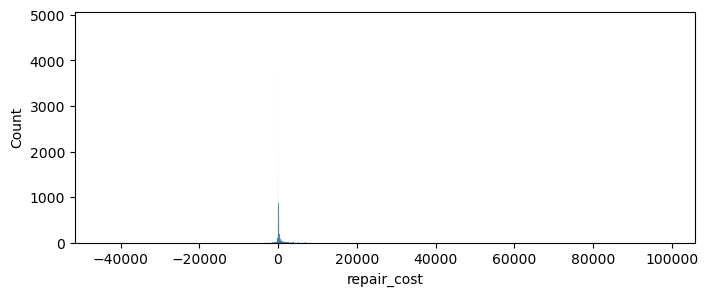

In [406]:
# visualize 'repair_cost'
plt.figure(figsize=(8, 3))
sns.histplot(df['repair_cost'])

<Axes: xlabel='repair_cost_log', ylabel='Count'>

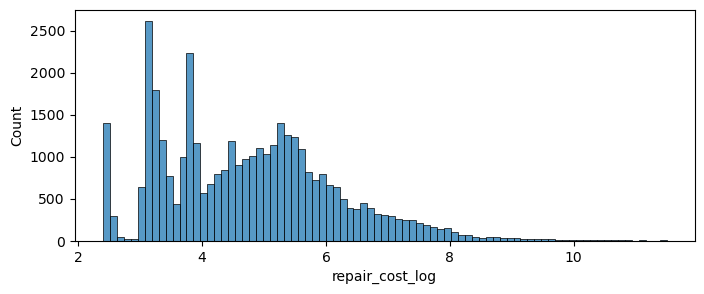

In [407]:
# invert negative values and log transform the feature
df['repair_cost_log'] = np.log1p(df['repair_cost'].abs())

# drop 'repair_complexity'
df = df.drop(['repair_cost'], axis=1)

# visualize 'repair_cost_log'
plt.figure(figsize=(8, 3))
sns.histplot(df['repair_cost_log'])

In [408]:
# To reduce the impact of outliers on the logistic regression model, let's apply RobustScaler

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df['repair_cost_scaled'] = scaler.fit_transform(df[['repair_cost_log']])

# drop 'repair_cost_log'
df = df.drop('repair_cost_log', axis=1)

<Axes: xlabel='repair_hours_log', ylabel='Count'>

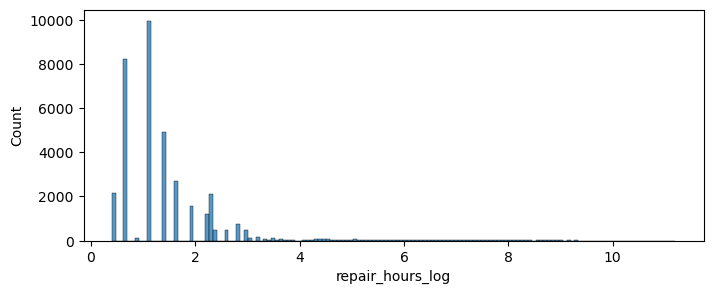

In [409]:
# 'repair_hours_log' feature is extremely skewed, so that the computer struggles to build a histplot for it
# let's first log transform it
df['repair_hours_log'] = np.log1p(df['repair_hours'])

# visualize 'repair_hours_log'
plt.figure(figsize=(8, 3))
sns.histplot(df['repair_hours_log'])

In [410]:
# The feature is heavily skewed even after log transformation
# Let's examine the distribution more closely

# Define the bins
bins = [0, 2, 10, 50, 100, 200, 500, 1000, 10000]

# Bin the repair_hours column
labels = ['0-2', '2-10', '10-50', '50-100', '100-200', '200-500', '500-1000', '1000-10000']
df['repair_hours_binned'] = pd.cut(df['repair_hours'], bins=bins, labels=labels, include_lowest=True)

# Count the rows in each bin
bin_counts = df['repair_hours_binned'].value_counts().sort_index()

# Print the counts
print(bin_counts)

repair_hours_binned
0-2           20464
2-10          13005
10-50          2374
50-100          324
100-200         314
200-500         393
500-1000        373
1000-10000      372
Name: count, dtype: int64


In [411]:
# To avoid dropping outliers (to prevent their negative impact on the model) let's bin the feature more tightly and one-hot-encode it

# Define the bins
bins = [0, 2, 10, 100, 10000]

# Bin and one-hot-encode the repair_hours column
labels = ['0-2', '2-10', '10-100', '100-10000']
df['repair_hours_binned'] = pd.cut(df['repair_hours'], bins=bins, labels=labels, include_lowest=True)
df = pd.get_dummies(df, columns=['repair_hours_binned'], prefix='repair_hours', drop_first=True)

# drop 'repair_hours' and 'repair_hours_log' as redundant
df = df.drop(['repair_hours', 'repair_hours_log'], axis=1)

## Cleaning categorical features

In [412]:
df.select_dtypes('object').describe(include='all').T

,count,unique,top,freq
maker,37636,25,Ford,18763
genmodel,37636,196,Focus,3612
genmodel_id,37636,195,29_14,3612
color,37636,22,Black,5825
bodytype,37636,15,Hatchback,20558
engine_size,37636,54,1.6L,8838
gearbox,37636,4,Manual,30980
fuel_type,37636,12,Petrol,21409
issue,37636,90,Transmission Issue,2350
breakdown_date,37636,930,2018-05-05,297


In [413]:
# Features 'maker' and 'genmodel' are related and can be combined into one feature
# Count the number of unique values in 'genmodel' for each 'maker'
df['genmodel'].groupby(df['maker']).nunique()

maker
Abarth         3
Bentley        7
Bugatti        1
Cadillac       3
Caterham       1
Chevrolet     16
Chrysler       8
Citroen       27
Corvette       1
DAX            1
DS             5
Dacia          4
Daewoo         2
Daihatsu       6
Daimler        1
Dodge          7
Ferrari       21
Fiat          28
Ford          33
GMC            1
Great Wall     1
Grinnall       1
Honda         17
Hummer         2
Hyundai        2
Name: genmodel, dtype: int64

In [414]:
# Combine maker and genmodel with grouping
df['maker_genmodel'] = df['maker'].astype(str) + '_' + df['genmodel'].astype(str)
combined_counts = df['maker_genmodel'].value_counts()
def group_rare_genmodels(row):
    maker = row['maker']
    maker_genmodel = row['maker_genmodel']
    maker_count = df['maker'].value_counts()[maker]
    threshold = max(376, maker_count * 0.01)
    if combined_counts[maker_genmodel] < threshold:
        return f"{maker}_Other"
    return maker_genmodel
df['maker_genmodel_grouped'] = df.apply(group_rare_genmodels, axis=1)
df = pd.get_dummies(df, columns=['maker_genmodel_grouped'], prefix='maker_genmodel', drop_first=True)
df = df.drop(['maker', 'genmodel', 'maker_genmodel'], axis=1)

In [415]:
df = df.drop('genmodel_id', axis=1)  # drop 'genmodel_id' as uninformative

In [416]:
df.color.value_counts()

color
Black          5825
Blue           5804
Silver         5552
Grey           4686
White          4504
Red            4221
Gelb           2944
Green           952
Brown           666
Yellow          660
Orange          491
Purple          469
Beige           295
Bronze          184
Gold            135
Pink            112
Multicolour     100
Turquoise        10
Magenta           9
Burgundy          8
Maroon            8
Indigo            1
Name: count, dtype: int64

In [417]:
# Group rare colors
color_counts = df['color'].value_counts()
colors_to_keep = color_counts[color_counts >= 376].index
df['color_grouped'] = df['color'].apply(lambda x: x if x in colors_to_keep else 'Other')
df = pd.get_dummies(df, columns=['color_grouped'], prefix='color', drop_first=True)
df = df.drop('color', axis=1)  # drop 'color' as uninformative

In [418]:
df['bodytype'].value_counts()

bodytype
Hatchback          20558
MPV                 6333
SUV                 5703
Estate              1296
Convertible         1292
Coupe                957
Pickup               654
Saloon               505
Wood                 122
Combi Van            102
Car Derived Van       47
Minibus               45
Panel Van             19
Window Van             2
Tipper                 1
Name: count, dtype: int64

In [419]:
# Group rare bodytypes
bodytype_counts = df['bodytype'].value_counts()
bodytypes_to_keep = bodytype_counts[bodytype_counts >= 376].index  # 1% of 37,636 ≈ 376
df['bodytypes_grouped'] = df['bodytype'].apply(lambda x: x if x in bodytypes_to_keep else 'Other')

# Clean the category names by replacing spaces with underscores
df['bodytypes_grouped'] = df['bodytypes_grouped'].str.replace(' ', '_')

# One-hot encode
df = pd.get_dummies(df, columns=['bodytypes_grouped'], prefix='bodytype', drop_first=True)

# Drop the original bodytype column
df = df.drop('bodytype', axis=1)

In [420]:
# check 'engine_size' feature
df['engine_size'].unique()

array(['1.0L', '2.0L', '1.25L', '1.2L', '2.5L', '1.6L', '1.4L', '2.2L',
       '0.9L', '6.0L', '1.3L', '1.5L', '4.3L', '1.8L', '6.2L', '1.1L',
       '1.9L', '5.0L', '5.5L', '2.8L', '4.0L', '3.2L', '999.0L', '4.5L',
       '2.3L', '2.4L', '0.8L', '3.9L', '6.3L', '3.0L', '3.6L', '1.7L',
       '4.7L', '3.3L', '5.7L', '6.5L', '3.7L', '6.75L', '2.7L', '6.8L',
       '3.5L', '5.2L', '0.66L', '2.9L', '5.3L', '6.7L', '6.4L', '6.1L',
       '5.4L', '7.0L', '3.8L', '4.6L', '5.8L', '4.2L'], dtype=object)

<Axes: xlabel='engine_size_numeric', ylabel='Count'>

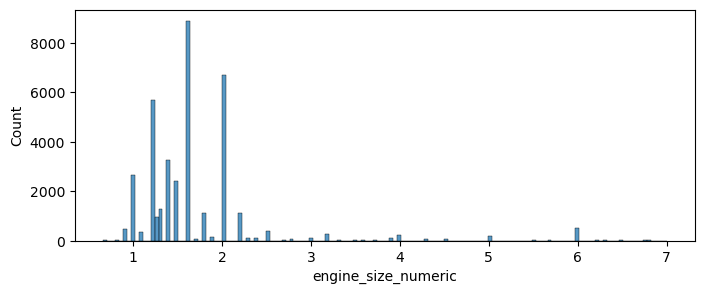

In [421]:
# Let's convert 'engine_size' to a numeric type and deal with obviously erroneous '999.0L' value

# Convert engine_size to numeric
df['engine_size_numeric'] = df['engine_size'].str.replace('L', '').astype(float)

# Handle the outlier (999.0L)
df['engine_size_numeric'] = df['engine_size_numeric'].replace(999.0, np.nan)
df['engine_size_numeric'] = df['engine_size_numeric'].fillna(df['engine_size_numeric'].median())

# Check the distribution of the cleaned engine_size
plt.figure(figsize=(8, 3))
sns.histplot(df['engine_size_numeric'])

In [422]:
# Scale the feature
scaler = RobustScaler()
df['engine_size_scaled'] = scaler.fit_transform(df[['engine_size_numeric']])

# Drop unnesessary columns
df = df.drop(['engine_size', 'engine_size_numeric'], axis=1)

In [423]:
# check 'gearbox' feature
df['gearbox'].value_counts()

gearbox
Manual            30980
Automatic          6607
Hybrid               27
Semi-Automatic       22
Name: count, dtype: int64

In [424]:
# Unite the rarest values (Hybrid, Semi-Automatic) into Automatic
df['gearbox'] = df['gearbox'].replace(['Hybrid', 'Semi-Automatic'], 'Automatic')

# Convert to binary (1 for Automatic, 0 for Manual)
df['gearbox_binary'] = df['gearbox'].map({'Automatic': 1, 'Manual': 0})

# Drop the original gearbox column
df = df.drop('gearbox', axis=1)

# Verify the result
print(df['gearbox_binary'].value_counts())

gearbox_binary
0    30980
1     6656
Name: count, dtype: int64


In [425]:
# check 'fuel_type' feature
df['fuel_type'].value_counts()

fuel_type
Petrol                                     21409
Diesel                                     14394
still_Diesel_but_you_found_an_easteregg     1586
Hybrid  Petrol/Electric                      159
Petrol Hybrid                                 40
Hydrogen                                      28
Electric                                       6
Hybrid  Diesel/Electric                        6
Bi Fuel                                        4
Petrol Ethanol                                 2
Hybrid  Petrol/Electric Plug-in                1
Petrol Plug-in Hybrid                          1
Name: count, dtype: int64

In [426]:
# Get rid of the easteregg :D
df['fuel_type'] = df['fuel_type'].replace('still_Diesel_but_you_found_an_easteregg', 'Diesel')

In [427]:
# join all 'Hybrids' together
mask = df['fuel_type'].str.contains('Hybrid', case=False)
df['fuel_type'] = df['fuel_type'].mask(mask, 'Hybrid')

In [428]:
# Unite low-frequency values (<376) into 'Other'
fuel_counts = df['fuel_type'].value_counts()
fuels_to_keep = fuel_counts[fuel_counts >= 376].index
df['fuel_type'] = df['fuel_type'].apply(lambda x: x if x in fuels_to_keep else 'Other')

# Verify the result
print(df['fuel_type'].value_counts())

fuel_type
Petrol    21409
Diesel    15980
Other       247
Name: count, dtype: int64


In [429]:
# One-hot encode the fuel_type feature
df = pd.get_dummies(df, columns=['fuel_type'], prefix='fuel_type', drop_first=True)


In [430]:
# check 'issue' feature
df['issue'].unique()


array(['Excessive Emissions', '  Radiator Leaking  ',
       '     Engine Issue     ', 'Flat Tyres', 'Windscreen Crack',
       'Transmission Issue', 'Alternator Failing', 'Brake Pads Worn',
       'Engine Issue', 'Tyre Alignment', 'Steering Wheel Shaking',
       'Radiator Leaking', 'Gear Box Issue', 'Starter Motor Issue',
       '    Transmission Issue    ', '  Tyre Alignment  ',
       'Electrical Issue', 'Sensor Malfunction',
       '    Radiator Leaking    ', '    Electrical Issue    ',
       'Warning Light', '  Excessive Emissions  ',
       '   Brake Pads Worn   ', '  Flat Tyres  ',
       '     Windscreen Crack     ', ' Transmission Issue ',
       '  Transmission Issue  ', '     Flat Tyres     ',
       '    Steering Wheel Shaking    ', '  Alternator Failing  ',
       '    Warning Light    ', '   Sensor Malfunction   ',
       ' Flat Tyres ', '    Starter Motor Issue    ',
       '  Steering Wheel Shaking  ', ' Brake Pads Worn ',
       '     Electrical Issue     ', '  Senso

In [431]:
# the feature has a lot of whitespaces, let's stip it
df['issue'] = df['issue'].apply(lambda x: x.strip())

In [432]:
# now we have a reasonable number of distinct values
df['issue'].value_counts()

issue
Flat Tyres                2609
Transmission Issue        2591
Alternator Failing        2586
Warning Light             2542
Brake Pads Worn           2535
Engine Issue              2531
Radiator Leaking          2530
Steering Wheel Shaking    2522
Windscreen Crack          2487
Starter Motor Issue       2483
Gear Box Issue            2481
Tyre Alignment            2475
Sensor Malfunction        2445
Electrical Issue          2422
Excessive Emissions       2397
Name: count, dtype: int64

In [433]:
# replace whitespaces with underscores in the issue values
df['issue'] = df['issue'].str.replace(' ', '_')

# One-hot encode the issue feature
df = pd.get_dummies(df, columns=['issue'], prefix='issue', drop_first=True)

In [434]:
# The last two features are 'breakdown_date' and 'repair_date'
# Let's combine them into one feature 'repair_duration' which will represent the time between breakdown and repair

# Convert the date columns to datetime
df['breakdown_date'] = pd.to_datetime(df['breakdown_date'])
df['repair_date'] = pd.to_datetime(df['repair_date'])

# Calculate the number of days between repair_date and breakdown_date
df['days_to_repair'] = (df['repair_date'] - df['breakdown_date']).dt.days

# Drop the original date columns
df = df.drop(['breakdown_date', 'repair_date'], axis=1)

<Axes: xlabel='days_to_repair', ylabel='Count'>

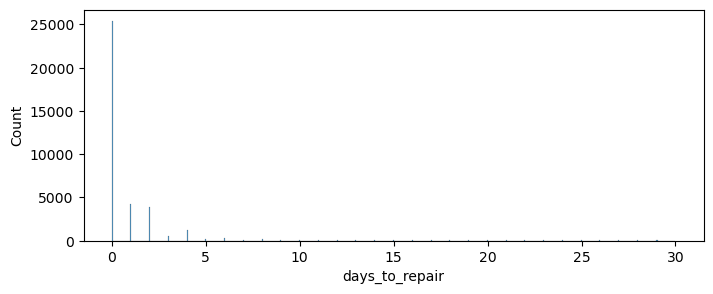

In [435]:
# Visualize the distribution of the 'days_to_repair' feature
plt.figure(figsize=(8, 3))
sns.histplot(df['days_to_repair'])

In [436]:
# log transform the feature as it looks highly right skewed
df['days_to_repair_log'] = np.log1p(df['days_to_repair'])
df = df.drop('days_to_repair', axis=1)

<Axes: xlabel='days_to_repair_log', ylabel='Count'>

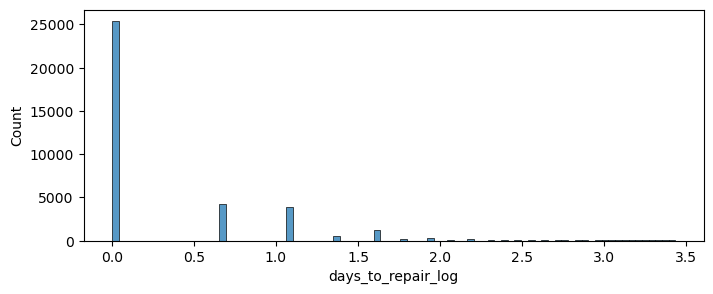

In [437]:
# Visualize the distribution of the 'days_to_repair' feature
plt.figure(figsize=(8, 3))
sns.histplot(df['days_to_repair_log'])

In [438]:
# It looks feasible (as the majority of values are zeroes) to add an additional binary feature to show whether the repair was done on the same day as the breakdown

# Create a binary indicator for zero values (same-day repairs)
df['is_same_day_repair'] = (df['days_to_repair_log'] == 0).astype(int)

# Scale the log-transformed feature
df['days_to_repair_log_scaled'] = scaler.fit_transform(df[['days_to_repair_log']])

# Drop the original and intermediate columns
df = df.drop(['days_to_repair_log'], axis=1)

In [ ]:
# The resulting dataframe contains 110 features which is quite a lot but still ok for such a big dataset
# Check the final shape of the dataframe
df.shape

(37636, 110)

In [440]:
# The dataframe contains 96 boolean 1/0 features
len(df.select_dtypes('bool').columns)

96

In [ ]:
# ... and 14 numeric features one of which is a target variable ('label')
len(df.select_dtypes('number').columns)

14

In [442]:
# Select boolean columns and convert to int
bool_cols = df.select_dtypes('bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Now all features are numeric
len(df.select_dtypes(np.number).columns)

110

In [443]:
# Test possible correlations between features to avoid multicollinearity

# Compute correlations, unstack, sort, and remove self-correlations
corr_series = df.corr().unstack().sort_values()
corr_series = corr_series[corr_series != 1.0]

# Remove duplicate pairs
corr_series = corr_series[corr_series.index.map(lambda x: x[0] < x[1])]

# Show the 5 most negative and 5 most positive correlations
print("Lowest correlations (most negative):")
print(corr_series.head())
print("\nHighest correlations (most positive):")
print(corr_series.tail())

Lowest correlations (most negative):
days_to_repair_log_scaled  is_same_day_repair   -0.832303
seat_num_4-5               seat_num_6-7         -0.786822
price_scaled               vehicle_age_scaled   -0.712522
is_same_day_repair         repair_cost_scaled   -0.605811
mileage_scaled             price_scaled         -0.537837
dtype: float64

Highest correlations (most positive):
maker_genmodel_Bentley_Continental  repair_complexity_3-4         0.585985
maker_genmodel_Citroen_Other        repair_complexity_2           0.595998
mileage_scaled                      vehicle_age_scaled            0.647483
engine_size_scaled                  repair_complexity_3-4         0.706512
bodytype_Pickup                     maker_genmodel_Ford_Ranger    0.936884
dtype: float64


In [444]:
# Possible multicollinearity between features 'bodytype_Pickup' and 'maker_genmodel_Ford_Ranger'
# Still let's keep them both as they represent different aspects of the data
# We'll regularize the model and see how it performs with all features